# **ResNet with TensorFlow**

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [41]:
# Load Cifar-10 data-set
(train_im, train_lab), (test_im, test_lab) = tf.keras.datasets.cifar10.load_data()

In [42]:
#### Normalize the images to pixel values (0, 1)
train_im, test_im = train_im/255.0 , test_im/255.0
#### Check the format of the data 
print ("train_im, train_lab types: ", type(train_im), type(train_lab))
#### check the shape of the data
print ("shape of images and labels array: ", train_im.shape, train_lab.shape) 
print ("shape of images and labels array ; test: ", test_im.shape, test_lab.shape)

train_im, train_lab types:  <class 'numpy.ndarray'> <class 'numpy.ndarray'>
shape of images and labels array:  (50000, 32, 32, 3) (50000, 1)
shape of images and labels array ; test:  (10000, 32, 32, 3) (10000, 1)


In [43]:
#### Check the distribution of unique elements 
(unique, counts) = np.unique(train_lab, return_counts=True)

frequencies = np.asarray((unique, counts)).T

print (frequencies)
print (len(unique))

[[   0 5000]
 [   1 5000]
 [   2 5000]
 [   3 5000]
 [   4 5000]
 [   5 5000]
 [   6 5000]
 [   7 5000]
 [   8 5000]
 [   9 5000]]
10


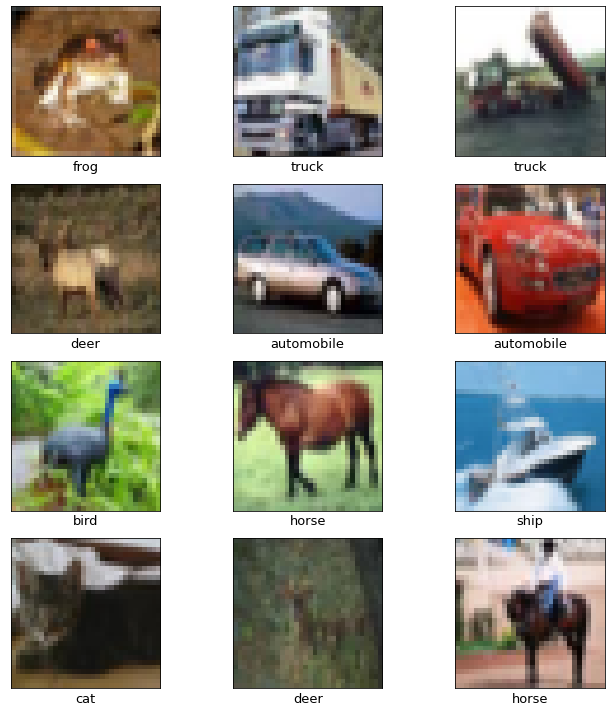

In [44]:
class_types = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck'] # from cifar-10 website

plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_im[i], cmap='gray')
    plt.xlabel(class_types[train_lab[i][0]], fontsize=13)
plt.tight_layout()    
plt.show()

In [45]:
### One hot encoding for labels 

train_lab_categorical = tf.keras.utils.to_categorical(train_lab, num_classes=10, dtype='uint8')

test_lab_categorical = tf.keras.utils.to_categorical(test_lab, num_classes=10, dtype='uint8')

In [46]:
### Train -test split 

from sklearn.model_selection import train_test_split 
train_im, valid_im, train_lab, valid_lab = train_test_split(train_im, train_lab_categorical, test_size=0.20, 
                                                            stratify=train_lab_categorical, 
                                                            random_state=40, shuffle = True)

print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000, 10)


In [47]:
##### Include Little Data Augmentation 
batch_size = 64 # try several values, 128,256

train_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
                                                                width_shift_range=0.1, 
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip=True)
 
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set_conv = train_DataGen.flow(train_im, train_lab, batch_size=batch_size) # train_lab is categorical 
valid_set_conv = valid_datagen.flow(valid_im, valid_lab, batch_size=batch_size) # so as valid_lab

#**Residual Block**

For more read check the original [Residual Net paper](https://arxiv.org/pdf/1512.03385.pdf). 

Then main idea is to train a very deep netowrk without degradation. 

Let's describe the Residual block in short. Below is a simplified picture-- 

<img src ="https://www.researchgate.net/profile/Kunjin_Chen/publication/325430477/figure/fig4/AS:633970848960514@1528161837288/An-illustration-of-the-modified-deep-residual-network-ResNetPlus-structure-The-blue.png">

**Why Resnet work?**

**Below is Andrew Ng's explanation :** 

Consider the activation function of layer l is $a^{[l]}$. In general in a node first we apply a linear operation (depending upon the layer weights and biases) and then apply the non-linearity (sigmoid, tanh, Relu etc.) operator. To write it in more simple terms, with reference to the figure -- 

$Z^{[l + 1]} = W^{[l + 1]}\, a^{[l]} + b^{[l+1]};\, a^{[l + 1]} = g\left(Z^{[l + 1]} \right)$ ... (1)

$Z^{[l + 2]} = W^{[l + 2]}\, a^{[l + 1]} + b^{[l+2]};\, a^{[l + 2]} = g\left(Z^{[l + 2]} \right)$ ... (2)

Including the Skip connection the activation $a^{[l]}$ will be sent (copied) much further into the network and add before applying the non-linearity. Let's see how the second equation changes in Resnet-- 

$Z^{[l + 2]} = W^{[l + 2]}\, a^{[l + 1]} + b^{[l+2]};\, a^{[l + 2]} = g\left(Z^{[l + 2]} + a^{[l]} \right)$ ...(3). 

The idea is to take many such resnet block and stack them together. The reason we can increase the depth of the network with training error continulously going down in resnet is becasue of the identity blocks. In equation 3, assuming L2 regularization, we can see that weights and biases would shrink (go close to zero) and thus $a^{[l+2]} = g(\sim 0+a^{[l]})$. With relu non-linearity function this would be $a^{[l+2]} \approx a^{[l]}$. Thus going deep doesn't hurt the performance as learning the identity function is easy and, in the process we can learn some more important features.  

The main building block of the ResNet are the residual blocks. The framework strictly stems from the previous ideas discussed. 

If we consider $x$ as input and the desired mapping from input to output is denoted by $g(x)$. We stack layers (including non-linearity coming from the activation function) to fit a different function $f(x) : = g(x) - x $. The original mapping is then recast to $f(x) + x$. He et.al. hypothesized that it is easier to optimize the residual $(f)$ than the original mapping $(g)$. The basic residual block is shown below --
![residual_block](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

One more important point to remember is about the dimension of the input $x$ and output $f(x)$. The building block can usually be defined as -- 
$y = f(x, \{W_i\}) + x$; 

and the network learns the residual mapping $f$. In the figure above there are 2 weight layers and an activation function in between in the residual block.  So $f = W_2\sigma (W_1x)$. Then $f+x$ is performed by elementwise addition. The skip/shortcut connection doesn't use any additional parameters. The dimesion of $f$ and $x$ must be equal, if this is not the case, then one can perform a linear projection $W_s$  by shortcut connection to match dimension. A square matrix $W_s$ can also be used ($y = f(x, \{W_i\}) + W_sx $) but the authors suggested that the identity conncection is sufficient to address the degradation problem. 

With all these in mind, let's implement ResNet. 

## **Build ResNet with TensorFlow**

We applied the activation after the batch norm but this is actually highly debatable on where to apply batch norm, before or after the activation layer. Here's a [stack post](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) on the topic.  Also instead of a 2 block skip connection we will use 3 block skip connection (discussed later). 
Let's just briefly some other important points related to the original resnet architecture, below is a picture of He et.al. paper --
![res_arch](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/Plot-of-Convolutional-Neural-Network-Architecture-with-a-Efficient-Inception-Module.png)  

Dimension remains same in solid line shortcuts and increases for dotted lines. 

The identity shorcut connections are directly used when input and output are of same dimensions. But when the dimensions are different the authors considered two options--

* Skip connection performs identity mapping but use zero padding for increased dimension. So no extra paramter added. 
* The projection shortcut (including matrix $W_s$ in the equation above) used to match dimension by $1\times 1 $ convlolutions. For both options when the shortcuts go across 2 feature maps of 2 sizes, they are performed with strides of 2.     

We will be working with a rather deep resnet-- 50 layers and we will follow the method authors described. For 50/100/150 layers authors used 3 blocks skip connection, as shown in the picture below-- 
![res50net](https://i.stack.imgur.com/gI4zT.png) 

The stacked 3 layers have filters $1\times 1, 3\times 3, 1\times 1$, where $1\times 1$ layers increase and decrease the dimension and $3\times 3$ layer acts as bottleneck with smaller input/output dimensions. As can be seen in the original resnet structure after the first pooling there's no pooling layer. So the dimension reduction is happening via $1\times 1$ convolution with strides 2.    

With the above picture and the important info let's build the architecture.   

In [48]:
resnet = tf.keras.applications.ResNet50(weights=None,classes=10,input_shape=(32,32,3))

In [49]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [50]:
### Define some Callbacks
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min')
  return estop

In [51]:
resnet.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
                       metrics=['acc'])

In [52]:
batch_size= 64

resnet_train = resnet.fit(train_set_conv, 
                          epochs=190, 
                          steps_per_epoch=train_im.shape[0]/batch_size, 
                          validation_steps=valid_im.shape[0]/batch_size, 
                          validation_data=valid_set_conv, 
                          callbacks=[lrdecay]
                          )

Epoch 1/190
625/625 [==============================] - 37s 51ms/step - loss: 2.4188 - acc: 0.2716 - val_loss: 7.3576 - val_acc: 0.3306
Epoch 2/190
625/625 [==============================] - 32s 51ms/step - loss: 1.8121 - acc: 0.3913 - val_loss: 2.3700 - val_acc: 0.3103
Epoch 3/190
625/625 [==============================] - 32s 51ms/step - loss: 1.8738 - acc: 0.3739 - val_loss: 1.5397 - val_acc: 0.4433
Epoch 4/190
625/625 [==============================] - 32s 51ms/step - loss: 1.7947 - acc: 0.4143 - val_loss: 2.4628 - val_acc: 0.2737
Epoch 5/190
625/625 [==============================] - 32s 51ms/step - loss: 1.8124 - acc: 0.4435 - val_loss: 1.5086 - val_acc: 0.4705
Epoch 6/190
625/625 [==============================] - 32s 51ms/step - loss: 1.5857 - acc: 0.4812 - val_loss: 9.3119 - val_acc: 0.1045
Epoch 7/190
625/625 [==============================] - 32s 50ms/step - loss: 1.7098 - acc: 0.4583 - val_loss: 2.0920 - val_acc: 0.3342
Epoch 8/190
625/625 [==============================] - 

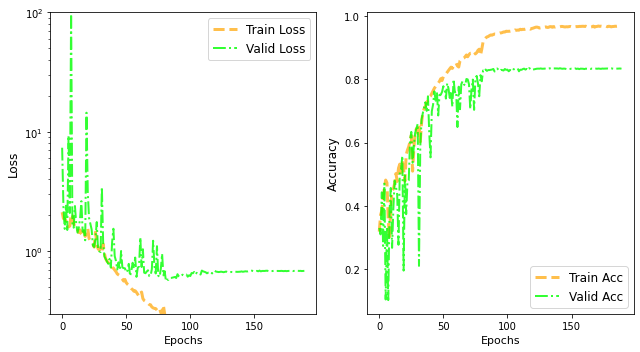

In [53]:
### Plot train and validation curves
loss = resnet_train.history['loss']
v_loss = resnet_train.history['val_loss']

acc = resnet_train.history['acc']
v_acc = resnet_train.history['val_acc']

epochs = range(len(loss))

fig = plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/train_acc.png', dpi=250)
plt.show()

In [54]:
#### Plot the Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def conf_matrix(predictions): 
    ''' Plots conf. matrix and classification report '''
    cm=confusion_matrix(test_lab, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr=classification_report(test_lab,
                                np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12,12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels = [class_types[i] for i in range(len(class_types))], 
                yticklabels = [class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()
    fig.savefig('/content/drive/My Drive/Colab Notebooks/heatmap.png', dpi=250)

Classification Report:

              precision    recall  f1-score   support

    airplane       0.73      0.87      0.79      1000
  automobile       0.89      0.93      0.91      1000
        bird       0.84      0.76      0.80      1000
         cat       0.71      0.59      0.65      1000
        deer       0.84      0.76      0.80      1000
         dog       0.76      0.71      0.73      1000
        frog       0.77      0.93      0.84      1000
       horse       0.88      0.88      0.88      1000
        ship       0.93      0.89      0.91      1000
       truck       0.86      0.91      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



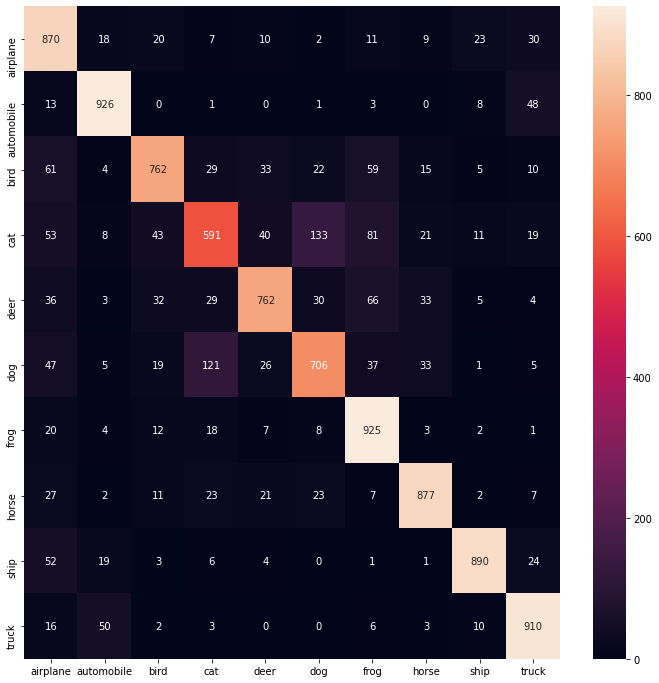

In [55]:
pred_class_resnet50 = resnet.predict(test_im)

conf_matrix(pred_class_resnet50)

In [56]:
### Resutls on Test Data; 
## Check the performance on the test data 
test_result = resnet.evaluate(test_im, test_lab_categorical, verbose=0)

print ("ResNet50 loss: ", test_result[0])
print ("ResNet50 accuracy: ", test_result[1])

ResNet50 loss:  0.7476455569267273
ResNet50 accuracy:  0.8281999826431274
